In [1]:
'''
This is a reimplementation of the varitional auto encoder based on the original paper "Auto-Encoding Variational Bayes". by Kingma et.al
'''

'\nThis is a reimplementation of the varitional auto encoder based on the original paper "Auto-Encoding Variational Bayes". by Kingma et.al\n'

# Imports, Setup, and Data preperation 

In [2]:
import torch
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
# set the batch size for pytorch data loader
batch_size = 128

In [4]:
# function to load MNIST dataset
def load_mnist(batch_size):
  mnist = MNIST("./", train=True, download=True, transform=transforms.Compose([
                                                                                transforms.ToTensor()]) )
  mnist_test = MNIST("./", train=False, download=True,  transform=transforms.Compose([
                                                                              transforms.ToTensor()]) )
  mnist_dataloader = DataLoader(mnist, batch_size=batch_size)
  mnist_test_dataloader = DataLoader(mnist_test, batch_size=batch_size)
  return mnist_dataloader, mnist_test_dataloader

In [5]:
# function to load MNIST dataset
def load_fashion_mnist(batch_size):
  fmnist = FashionMNIST("./", train=True, download=True, transform=transforms.Compose([
                                                                                transforms.ToTensor()]) )
  fmnist_test = FashionMNIST("./", train=False, download=True,  transform=transforms.Compose([
                                                                              transforms.ToTensor()]) )
  fmnist_dataloader = DataLoader(fmnist, batch_size=batch_size)
  fmnist_test_dataloader = DataLoader(fmnist_test, batch_size=batch_size)
  return fmnist_dataloader, fmnist_test_dataloader

In [6]:
# function to load frey face dataset
def load_frey_face(batch_size):
  # download the data
  ! wget https://cs.nyu.edu/~roweis/data/frey_rawface.mat

  fileName = "frey_rawface.mat"
  frey_face_mat = loadmat(fileName) # load the mat file
  frey_face_input = torch.tensor( frey_face_mat['ff'].T.reshape(-1, 1, 28, 20))
  dummy_targets = torch.zeros(frey_face_input.shape[0])
  # print(frey_face_input[0])
  size = frey_face_input.shape[0]
  train_size = int(0.9 * size)

  # normalize the input between 0 and 1
  frey_face_input = (frey_face_input - frey_face_input.min()) / (frey_face_input.max() - frey_face_input.min())


  frey_face = TensorDataset((frey_face_input[: train_size]), dummy_targets[: train_size])
  frey_face_test = TensorDataset((frey_face_input[train_size: ]), dummy_targets[train_size:])

  frey_face_dataloader = DataLoader(frey_face, batch_size=batch_size)
  frey_face_test_dataloader = DataLoader(frey_face_test, batch_size=batch_size)
  return frey_face_dataloader, frey_face_test_dataloader

In [7]:
# plot a batch of images as a grid.
def plot_grid(dataloader):
  images, _ = next(iter(dataloader))
  grid = make_grid(images, )
  plt.figure(figsize=(10, 10))
  plt.imshow(grid.permute(1, 2, 0))

In [10]:
# load the data
mnist, mnist_test = load_mnist(batch_size)
fmnist, fmnist_test = load_fashion_mnist(batch_size)
# freyface, freyface_test = load_frey_face(batch_size)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



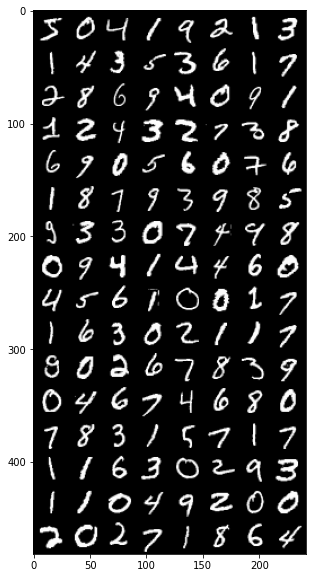

In [11]:
# plot a grid of images
plot_grid(mnist)

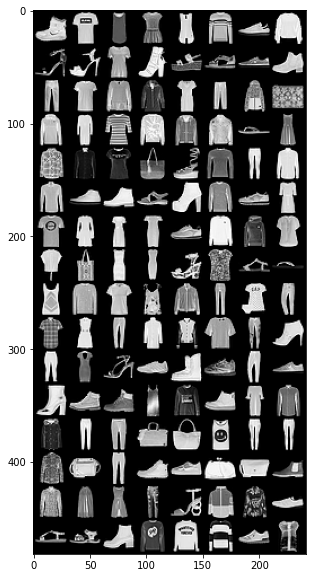

In [12]:
# plot a grid of images
plot_grid(fmnist)

In [13]:
# plot_grid(freyface)

In [14]:
# image, _ = next(iter(freyface))
# image

# Model Architecture 

In [15]:
class Encoder(nn.Module):
  '''
  This class defines the encoder architecture
  '''
  def __init__(self, input_size, hidden_size, bottleneck):
    super().__init__()
    self.linear1 = nn.Linear(input_size, hidden_size)
    self.mean = nn.Linear(hidden_size, bottleneck)
    self.var = nn.Linear(hidden_size, bottleneck) 

    nn.init.normal_(self.linear1.weight, mean=0.0, std=0.01)
    nn.init.normal_(self.mean.weight, mean=0.0, std=0.01)
    nn.init.normal_(self.var.weight, mean=0.0, std=0.01)
    

  def forward(self, x):
    mean = self.mean(torch.tanh(self.linear1(x)))
    log_var =  self.var(torch.tanh(self.linear1(x)))
    return mean, log_var

In [16]:
class Decoder(nn.Module):
  '''
  This class defines the decoder architecture
  '''
  def __init__(self, bottleneck, hidden_size, input_size):
    super().__init__()
    self.linear1 = nn.Linear(bottleneck, hidden_size)
    # self.linear2 = nn.Linear(hidden_size, hidden_size)
    self.mean = nn.Linear(hidden_size, input_size)

    nn.init.normal_(self.linear1.weight, mean=0.0, std=0.01)
    nn.init.normal_(self.mean.weight, mean=0.0, std=0.01)

  def forward(self, x, output_activation=None):
    mean = self.mean(torch.tanh(self.linear1(x)))
    if output_activation:
      return output_activation(mean)
    return mean

# Loss function and Training loop

In [23]:
def vae_loss(logvar_z, mean_z, output, target, size, batch_size, mse=True):
  # KL Divergence between the prior and the posterior
  kl_divergence = - 0.5 * (torch.sum(1 + logvar_z - mean_z.pow(2) - logvar_z.exp(), dim=1)).sum()
  # reconstruction loss
  if mse:
    reconstruction_loss = F.mse_loss(output, target, reduction="sum")
  else:
    reconstruction_loss = F.binary_cross_entropy(output, target, reduction="sum")
  loss =  (1/batch_size) * ( kl_divergence +  reconstruction_loss)
  return loss

In [18]:
# simple function to implemenet the reparametrization trick
def reparametrization(mean, logv):
  eps = torch.normal(0, 1, size=mean.shape, device=device)
  z = mean + (eps * logv.exp().pow(0.5))
  return z

In [19]:
def train(encoder, decoder, loss, optimizer, dataloader, epochs, dataset_size, testloader, channels=1, height=28, width=28, plot=True, mse=False,  activation=True, data="mnist", plot_freq=10):
  losses = []
  test_losses = []
  # Main training loop
  inputs = None
  outputs = None
  for epoch in range(epochs):
    for img, _ in dataloader:
      inputs = torch.clone(img)
      if data == "freyface":
        img_flattend = img.reshape(-1, (torch.tensor(img.shape[1:])).prod())
      else:
        img_flattend = img.reshape(-1, (torch.tensor(img.shape[1:])).prod())
      mu, logv = encoder(img_flattend.to(device))
      z = reparametrization(mu, logv)
      if activation:
        output = decoder(z.to(device), torch.sigmoid)
      else:
        output = decoder(z.to(device))
      outputs = torch.clone(output)
      loss = vae_loss(logv.to(device), mu.to(device), output.to(device), img_flattend.to(device), dataset_size, len(img), mse=mse)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    losses.append(-loss)

    # plot some results every 10 epochs
    if (epoch+1) % plot_freq == 0 :
      targets = inputs[:128]
      output_reshaped = outputs.reshape(-1, channels, height, width)[:128]
      target_grid = make_grid(targets.cpu().detach(), nrow=6)
      if mse:
        output_grid = make_grid(output_reshaped.cpu().detach(), nrow=6)
      else:
        output_grid = make_grid(output_reshaped.cpu().detach(), nrow=6)
      if plot:
        plt.figure(figsize=(15, 10))
        plt.imshow(target_grid.permute(1, 2, 0))
        plt.figure(figsize=(15, 10))
        plt.imshow(output_grid.permute(1, 2, 0))
        plt.show()

    # evaluate on the test set
    with torch.no_grad():
      for img, _ in testloader:
        if data == "freyface":
          img_flattend = img.reshape(-1, (torch.tensor(img.shape[1:])).prod())
        else:
          img_flattend = img.reshape(-1, (torch.tensor(img.shape[1:])).prod())
        mu, logv = encoder(img_flattend.to(device))
        z = reparametrization(mu, logv)
        if activation:
          output = decoder(z.to(device), torch.sigmoid)
        else:
          output = decoder(z.to(device))
        test_loss = vae_loss(logv.to(device), mu.to(device), output.to(device), img_flattend.to(device), dataset_size, len(img), mse=mse)
        # test_loss = vae_loss(logv.to(device), mu.to(device), output.to(device), img_flattend.to(device), 60000, len(img), mse=False)
      test_losses.append(- test_loss)

      print(f"Epoch: {epoch+1}, train loss: {loss}, test loss: {test_loss}")

  return losses, test_losses,target_grid, output_grid

# Test for the implementation

In [ ]:
hidden_size = 500
bottleneck = 5
input_size = 784
stepsize = 0.01
epochs = 100
# add the parameters for weight initlization

In [ ]:
encoder = Encoder(input_size, hidden_size, bottleneck).to(device) # define the encoder
decoder = Decoder(bottleneck, hidden_size, input_size).to(device) # define the decoder
optimizer = opt.Adagrad(list(encoder.parameters()) + list(decoder.parameters()) , lr=stepsize, weight_decay=1) # define the optimizer

train(encoder, decoder, vae_loss, optimizer, mnist, epochs, dataset_size=60000, testloader=mnist_test)

# Experimental Setup

In [20]:
def experiment(epochs,input_size, hidden_size, bottleneck, height=None, width=None, plot_freq=10):
  # save image for comparison
  encoder = Encoder(input_size, hidden_size, bottleneck).to(device) # define the encoder
  decoder = Decoder(bottleneck, hidden_size, input_size).to(device) # define the decoder

  optimizer = opt.Adagrad(list(encoder.parameters()) + list(decoder.parameters()) , lr=stepsize) # define the optimizer
  if height != None and width != None:
    loss, test_loss, data, output = train(encoder, decoder, vae_loss, optimizer, freyface, epochs, dataset_size=1950, plot=True, testloader=freyface_test, height=height, width=width, data="freyface", mse=False, plot_freq=plot_freq, activation=True)
  else:
    loss, test_loss, data, output = train(encoder, decoder, vae_loss, optimizer, mnist, epochs, dataset_size=6000, plot=True, testloader=mnist_test, activation=True, mse=False, plot_freq=plot_freq)

  return loss, test_loss, data, output

In [21]:
def plot_loss(loss, loss_test, n, data="MNIST"):
  x_labels = [i*10**6 for i in range(1,len(loss)+1)]
  plt.plot(x_labels, loss, '-r', label="AEVB (train)")
  plt.plot(x_labels, loss_test, '--r', label="AEVB (test)")
  plt.xscale('log')
  plt.xlabel("# Training samples evaluated")
  plt.ylabel("Loss")
  plt.legend()
  plt.savefig(f"{data} N={n}")

# MNIST Experiment

Epoch: 1, train loss: 188.44845581054688, test loss: 181.982421875
Epoch: 2, train loss: 181.20455932617188, test loss: 178.9534912109375
Epoch: 3, train loss: 185.12869262695312, test loss: 179.69955444335938
Epoch: 4, train loss: 176.2313232421875, test loss: 176.5464324951172
Epoch: 5, train loss: 172.64846801757812, test loss: 170.68910217285156
Epoch: 6, train loss: 170.68101501464844, test loss: 167.6195526123047
Epoch: 7, train loss: 168.358642578125, test loss: 167.4851531982422
Epoch: 8, train loss: 166.35897827148438, test loss: 161.8463592529297
Epoch: 9, train loss: 165.81039428710938, test loss: 161.27931213378906


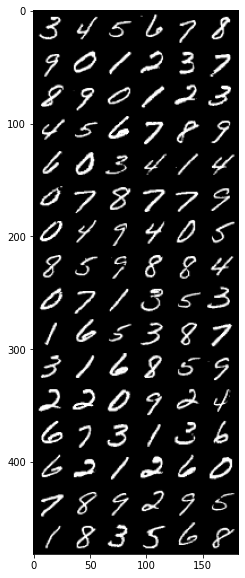

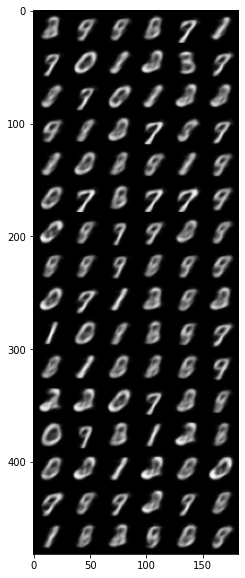

Epoch: 10, train loss: 163.689697265625, test loss: 162.2013702392578
Epoch: 11, train loss: 162.285888671875, test loss: 158.27317810058594
Epoch: 12, train loss: 161.15635681152344, test loss: 158.36094665527344
Epoch: 13, train loss: 159.06256103515625, test loss: 155.92681884765625
Epoch: 14, train loss: 160.3251953125, test loss: 156.76788330078125
Epoch: 15, train loss: 157.56504821777344, test loss: 156.80616760253906
Epoch: 16, train loss: 158.6724853515625, test loss: 159.774169921875
Epoch: 17, train loss: 159.60279846191406, test loss: 157.34461975097656
Epoch: 18, train loss: 156.6375732421875, test loss: 155.09158325195312
Epoch: 19, train loss: 158.95578002929688, test loss: 157.04600524902344


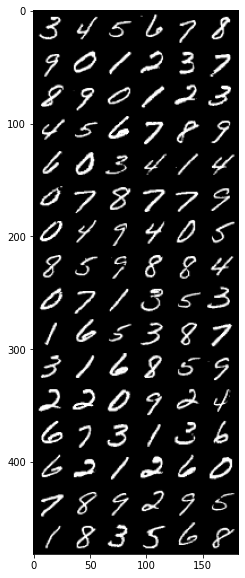

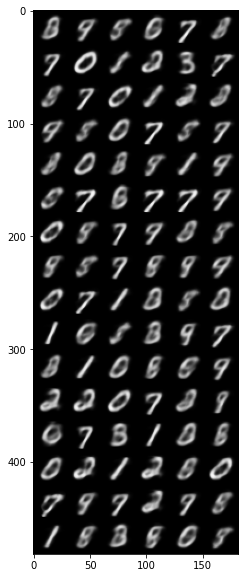

Epoch: 20, train loss: 154.0785369873047, test loss: 153.2974090576172
Epoch: 21, train loss: 156.37518310546875, test loss: 158.29783630371094
Epoch: 22, train loss: 153.2265625, test loss: 151.76759338378906
Epoch: 23, train loss: 153.07391357421875, test loss: 153.130859375
Epoch: 24, train loss: 152.70138549804688, test loss: 151.9322052001953
Epoch: 25, train loss: 151.81179809570312, test loss: 153.7104949951172
Epoch: 26, train loss: 152.14468383789062, test loss: 151.56271362304688
Epoch: 27, train loss: 150.81466674804688, test loss: 151.21168518066406
Epoch: 28, train loss: 150.91017150878906, test loss: 151.1986541748047
Epoch: 29, train loss: 151.6528778076172, test loss: 152.2099609375


KeyboardInterrupt: ignored

In [24]:
# Experemints setup for MNIST
# Networks parameters
hidden_size = 500
input_size = 784
# different size of the latent space
N = [3, 5, 10, 20, 200]
epochs = 150
stepsize = 0.03
for bottleneck in N:
  loss, test_loss, data, output = experiment(epochs,input_size, hidden_size, bottleneck)
  if bottleneck == N[0]:
    print(f"Original images")
    plt.figure(figsize=(15, 10))
    plt.imshow(data.permute(1, 2, 0))
    plt.savefig("original_image")
    plt.show()
  print(f"MNIST Image Generated with latent space size of {bottleneck}")
  plt.figure(figsize=(15, 10))
  plt.imshow(output.permute(1, 2, 0))
  plt.savefig(f"MNIST Image Generated with latent space size of {bottleneck}")
  plt.show()
  print(f"Losses for N={bottleneck}")
  plot_loss(loss, test_loss, bottleneck)

# Fashion MNIST Experiment

In [ ]:
# Experemints setup for MNIST
# Networks parameters
hidden_size = 500
input_size = 784
# different size of the latent space
N = [3, 5, 10, 20, 200]
epochs = 150
stepsize = 0.03
for bottleneck in N:

  encoder = Encoder(input_size, hidden_size, bottleneck).to(device) # define the encoder
  decoder = Decoder(bottleneck, hidden_size, input_size).to(device) # define the decoder
  optimizer = opt.Adagrad(list(encoder.parameters()) + list(decoder.parameters()) , lr=stepsize) # define the optimizer

  loss, test_loss, data, output = train(encoder, decoder, vae_loss, optimizer, fmnist, epochs, dataset_size=6000, plot=True, testloader=fmnist_test, activation=True, mse=False, plot_freq=100)

  # loss, test_loss, data, output = experiment(epochs,input_size, hidden_size, bottleneck)
  if bottleneck == N[0]:
    print(f"Original images")
    plt.figure(figsize=(15, 10))
    plt.imshow(data.permute(1, 2, 0))
    plt.savefig("original_image")
    plt.show()
  print(f"FMNIST Image Generated with latent space size of {bottleneck}")
  plt.figure(figsize=(15, 10))
  plt.imshow(output.permute(1, 2, 0))
  plt.savefig(f"FMNIST Image Generated with latent space size of {bottleneck}")
  plt.show()
  print(f"Losses for N={bottleneck}")
  plot_loss(loss, test_loss, bottleneck)

Epoch: 1, train loss: 320.2996520996094, test loss: 310.186767578125
